# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №2: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 24 марта 18:00 Сдача **очная** на занятии. <br\>


Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст, если явно не указана такая возможность. В противном случае -1 балл
<hr\>

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

Здравствуйте, уважаемые студенты! 

В этом задании мы будем реализовать линейные модели. Необходимо реализовать линейную и логистическую регрессии с L2 регуляризацией

# Теоретическое введение



Линейная регрессия решает задачу регрессии и оптимизирует функцию потерь MSE 

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right], $$ где $y_i$ $-$ целевая функция,  $a_i = a(x_i) =  \langle\,x_i,w\rangle ,$ $-$ предсказание алгоритма на объекте $x_i$, $w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Не забываем, что здесь и далее  мы считаем, что в $x_i$ есть тождественный вектор единиц, ему соответствует вес $w_0$.


Логистическая регрессия является линейным классификатором, который оптимизирует так называемый функционал log loss:

$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right],$$
где  $y_i  \in \{0,1\}$ $-$ метка класса, $a_i$ $-$ предсказание алгоритма на объекте $x_i$. Модель пытается предсказать апостериорую вероятность объекта принадлежать к классу "1":
$$ p(y_i = 1 | x_i) = a(x_i) =  \sigma( \langle\,x_i,w\rangle ),$$
$w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Функция $\sigma(x)$ $-$ нелинейная функция, пероводящее скалярное произведение объекта на веса в число $\in (0,1)$ (мы же моделируем вероятность все-таки!)

$$\sigma(x) = \frac{1}{1 + \exp(-x)}$$

Если внимательно посмотреть на функцию потерь, то можно заметить, что в зависимости от правильного ответа алгоритм штрафуется или функцией $-\log a_i$, или функцией $-\log (1 - a_i)$.



Часто для решения проблем, которые так или иначе связаны с проблемой переобучения, в функционал качества добавляют слагаемое, которое называют ***регуляризацией***. Итоговый функционал для линейной регрессии тогда принимает вид:

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right] + \frac{1}{C}R(w) $$

Для логистической: 
$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right] +  \frac{1}{C}R(w)$$

Самое понятие регуляризации введено основателем ВМК академиком Тихоновым https://ru.wikipedia.org/wiki/Метод_регуляризации_Тихонова

Идейно методика регуляризации заключается в следующем $-$ мы рассматриваем некорректно поставленную задачу (что это такое можно найти в интернете), для того чтобы сузить набор различных вариантов (лучшие из которых будут являться переобучением ) мы вводим дополнительные ограничения на множество искомых решений. На лекции Вы уже рассмотрели два варианта регуляризации.

$L1$ регуляризация:
$$R(w) = \sum_{j=1}^{D}|w_j|$$
$L2$ регуляризация:
$$R(w) =  \sum_{j=1}^{D}w_j^2$$

С их помощью мы ограничиваем модель в  возможности выбора каких угодно весов минимизирующих наш лосс, модель уже не сможет подстроиться под данные как ей угодно. 

Вам нужно добавить соотвествущую Вашему варианту $L2$ регуляризацию.

И так, мы поняли, какую функцию ошибки будем минимизировать, разобрались, как получить предсказания по объекту и обученным весам. Осталось разобраться, как получить оптимальные веса. Для этого нужно выбрать какой-то метод оптимизации.



Градиентный спуск является самым популярным алгоритмом обучения линейных моделей. В этом задании Вам предложат реализовать стохастический градиентный спуск или  мини-батч градиентный спуск (мини-батч на русский язык довольно сложно перевести, многие переводят это как "пакетный", но мне не кажется этот перевод удачным). Далее нам потребуется определение **эпохи**.
Эпохой в SGD и MB-GD называется один проход по **всем** объектам в обучающей выборки.
* В SGD градиент расчитывается по одному случайному объекту. Сам алгоритм выглядит примерно так:
        1) Перемешать выборку
        2) Посчитать градиент функции потерь на одном объекте (далее один объект тоже будем называть батчем)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* В Mini Batch SGD - по подвыборке объектов. Сам алгоритм выглядит примерно так::
        1) Перемешать выборку, выбрать размер мини-батча (от 1 до размера выборки)
        2) Почитать градиент функции потерь по мини-батчу (не забыть поделить на  число объектов в мини-батче)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* Для отладки алгоритма реализуйте возможность  вывода средней ошибки на обучении модели по объектам (мини-батчам). После шага градиентного спуска посчитайте значение ошибки на объекте (или мини-батче), а затем усредните, например, по ста шагам. Если обучение проходит корректно, то мы должны увидеть, что каждые 100 шагов функция потерь уменьшается. 
* Правило останова - максимальное количество эпох
    


# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Градиент для линейной регрессии.
* Выпишите формулу обновления весов для линейной регрессии с L2 регуляризацией для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент?

***Ваше решение здесь***
$$ w_{new} = w_{old} - {\alpha}{\nabla}_w L(w_{old}) $$
$$ L(w) = \frac{1}{n} \sum_{i = 1}^{n} (y_i - <x_i , w>)^2 + \frac{1}{C} \sum_{i=1}^{D} w_j^2  $$
$$w_{new} = w_{old} - 2 \alpha ( \frac{1}{n} \sum_{i = 1}^{n} ( \langle x_{i}, w_{old} \rangle - y_{i})x_{i} + \frac{w_{old}}{C})$$

 $\alpha$ - шаг оптимизации, который может быть задан невозрастающей функцией $f(k)$ от номера $k$ шага оптимизации

Задача 2. Градиент для логистической регрессии.
* Выпишите формулу обновления весов для логистической регрессии с L2 регуляризацией  для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент? Как соотносится этот градиент с градиентом, возникающий в задаче линейной регрессии?

Подсказка: Вам градиент, которой получается если “в лоб” продифференцировать,  надо немного преобразовать.
Надо подставить, что $1 - \sigma(w,x) $ это  $1 - a(x_i)$, а  $-\sigma(w,x)$ это $0 - a(x_i)$.  Тогда получится свести к одной красивой формуле с линейной регрессией, которую программировать будет намного проще.

***Ваше решение здесь***

$$ w_{new} = w_{old} - \alpha \nabla_{w}L(w_{old})$$

$$a_i = \frac{1}{1 + \exp(-<x_i, w>)}$$

$$L(w) = - \frac{1}{n}\left[\sum_{i=1}^n y_i \log_2 a_i + ( 1 - y_i) \log_2 (1 - a_i) \right] +  \frac{1}{C} \sum_{i=1}^{D} w_j^2$$

$$ w_{new} = w_{old} - \alpha (\frac{1}{nln2} \sum_{i = 1}^{n} \frac{((1 - y_{i})e^{\langle x_{i}, w_{old} \rangle} - y_{i})x_{i}}{e^{\langle x_{i}, w_{old} \rangle} + 1} + \frac{2 w_{old}}{C})= $$
$$ = w_{old} - \alpha (\frac{1}{nln2} \sum_{i = 1}^{n} \frac{((1 - y_{i}) - y_{i}e^{- \langle x_{i}, w_{old} \rangle})x_{i}}{1 + e^{- \langle x_{i}, w_{old} \rangle}} + \frac{2 w_{old}}{C})$$
$$ w_{new} = w_{old} - \alpha (\frac{1}{nln2} \sum_{i = 1}^{n} (\frac{1}{1 + e^{- \langle x_{i}, w_{old} \rangle}} - y_{i})x_{i} + \frac{2 w_{old}}{C})$$
Общая формула для двух алгоритмов имеет вид:
$$ w_{new} = w_{old} - 2\alpha (\frac{C_1}{n} \sum_{i = 1}^{n} (a(x_{i}) - y_{i})x_{i} + \frac{w_{old}}{C})$$
где $C_1 = 1$ для линейной регресии, $C_1 = \frac{1}{2 \ln 2}$ для логистической

Задача 3. Точное решение линейной регрессии

На лекции было показано, что точное решение линейной регрессии имеет вид $w = (X^TX)^{-1}X^TY $. 
* Покажите, что это действительно является точкой минимума в случае, если матрица X имеет строк не меньше, чем столбцов и имеет полный ранг. Подсказка: посчитайте Гессиан и покажите, что в этом случае он положительно определен. 
* Выпишите точное решение для модели с $L2$ регуляризацией. Как L2 регуляризация помогает с точным решением где матрица X имеет линейно зависимые признаки?

***Ваше решение здесь***

Матрица Гессе:
$$ H(Q(w)) =
 \begin{pmatrix}
  \frac{\partial^{2} Q}{\partial w_{0}^{2}} & \frac{\partial^{2} Q}{\partial w_{0} \partial w_{1}} & \cdots & \frac{\partial^{2} Q}{\partial w_{0} \partial w_{D}} \\
  \frac{\partial^{2} Q}{\partial w_{1} \partial w_{0}} & \frac{\partial^{2} Q}{\partial w_{0}^{1}} & \cdots & \frac{\partial^{2} Q}{\partial w_{1} \partial w_{D}} \\
  \vdots  & \vdots  &  \frac{\partial^{2} Q}{\partial w_{i} \partial w_{j}} & \vdots  \\
  \frac{\partial^{2} Q}{\partial w_{D} \partial w_{0}} & \frac{\partial^{2} Q}{\partial w_{D} \partial w_{1}} & \cdots & \frac{\partial^{2} Q}{\partial w_{D}^{2}} 
 \end{pmatrix}$$
 
 где 
 $$Q(w) = \frac{1}{n} \sum_{i=1}^{n} (x_i w - y_i)^2 = \frac{1}{n} || Xw - y ||^2 = $$ $$ = \frac{1}{n} (Xw-y)^T (Xw-y) =  \frac{1}{n}(w^{T} X^{T} X w - w^{T} X^{T}y - y^{T}Xw + y^{T}y)$$
 
 $X, x_i, y, w$ - матрица признаков объектов размера $ n \times D$ и векторы признаков $i$-го объекта, ответов и весов соответственно
 
 Далее при поиске минимума деление на $n$ можно опустить
 
 $$ H(Q(w)) = 2
 \begin{pmatrix}
  x_{0}^{T}x_{0} & x_{0}^{T}x_{1} & \cdots & x_{0}^{T}x_{D} \\
  x_{1}^{T}x_{0} & x_{1}^{T}x_{1} & \cdots & x_{1}^{T}x_{D} \\
  \vdots  & \vdots  & x_{i}^{T}x_{j} & \vdots  \\
  x_{D}^{T}x_{0} & x_{D}^{T}x_{1} & \cdots & x_{D}^{T}x_{D}
 \end{pmatrix}$$
 
 $ H(Q(w)) = 2 X^{T}X \implies \exists B = \sqrt{2} X: B^{T}B = H(Q(w))$. $X$ невырождена, так как имеет строк не меньше, чем столбцов и полный ранг, поэтому $ H(Q(w))$ положительно определена. 
 
Решение для линейной регрессии с L2 регуляризацией: 
$$Q(w) = \frac{1}{n}(w^{T} X^{T} X w - w^{T} X^{T}y - y^{T}Xw + y^{T}y) + \frac{1}{C}w^{T}w$$
$$ \nabla_{w}Q(w) = 2X^{T}Xw - 2X^{T}y + \frac{2}{C}Iw $$
$$ \nabla_{w} Q(w) = 0 \iff w = (X^{T}X + \frac{I}{C})^{-1} X^{T}y $$

Задача 4.  Предсказываем вероятности.

Когда говорят о логистической регрессии, произносят фразу, что она "предсказывает вероятности положительного класса". Давайте разберемся, что же за этим стоит. Посчитаем математическое ожидание функции потерь и проверим, что предсказание алгоритма, оптимизирующее это мат. ожидание, будет являться вероятностью положительного класса. 

И так, функция потерь на объекте $x_i$, который имеет метку $y_i \in \{0,1\}$  для предсказания $a(x_i)$ равна:
$$L(y_i, b) =-[y_i == 1] \log a(x_i)  - [y_i == 0] \log(1 - a(x_i)) $$

Где $[]$ означает индикатор $-$ он равен единице, если значение внутри него истинно, иначе он равен нулю. Тогда мат. ожидание при условии конкретного $x_i$  по определение мат. ожидания дискретной случайной величины:
$$E(L | x_i) = -p(y_i = 1 |x_i ) \log a(x_i)  - p(y_i = 0 | x_i) \log( 1 - a(x_i))$$
* Докажите, что значение $a(x_i)$, минимизирующее данное мат. ожидание, в точности равно $p(y_i = 1 |x_i)$, то есть равно вероятности положительного класса.

Подсказка: возможно, придется воспользоваться, что  $p(y_i = 1 | x_i) + p(y_i = 0 | x_i) = 1$

***Ваше решение здесь***

$$\frac{dE(L|x_i)}{da(x_i)} = \frac{1}{\ln2}(\frac{-p(y_i = 1 |x_i)}{a(x_i)} + \frac{p(y_i = 0 | x_i)}{1 - a(x_i)
})$$

$$\frac{dE(L|x_i)}{da(x_i)} = \frac{-p(y_i = 1 |x_i) + a(x_i)p(y_i = 1 |x_i) + a(x_i)p(y_i = 0 | x_i)}{\ln 2 \cdot a(x_i)(1 - a(x_i))}$$ 

Учитывая, что $p(y_i = 1 | x_i) + p(y_i = 0 | x_i) = 1$, получим:

$$\frac{dE(L|x_i)}{da(x_i)} = \frac{a(x_i) - p(y_i = 1 |x_i)}{\ln 2 \cdot a(x_i)(1 - a(x_i))}$$

$$ \frac{dE(L|x_i)}{da(x_i)} = 0 \iff \begin{cases} a(x_i) \neq 0\\ a(x_i) \neq 1\\ a(x_i) = p(y_i = 1 |x_i) \end{cases} $$

Вычислим вторую производную по $a(x_i)$
$$ \frac{d}{da(x_i)} \begin{pmatrix} \frac{a(x_i) - p(y_i = 1 |x_i)}{\ln 2 * a(x_i) (1-a(x_i))} \end{pmatrix} =   \frac{\ln 2 * a(x_i)(1-a(x_i)) - \ln 2 * (a(x_i) - p(y_i = 1 |x_i)) (1 - 2a(x_i))}{\ln^2 2 * a^2(x_i)(1-a(x_i))^2 } = $$ $$ = \frac{a^2(x_i) + p(y_i = 1 |x_i) (1-2a(x_i))}{\ln 2 * a^2(x_i)(1-a(x_i))^2} $$

Вторая производная положительна при $ a(x_i) = p(y_i = 1 |x_i)$. Следовательно, $a(x_i) = p(y_i = 1 |x_i)$ действительно является точкой минимума математического ожидания

Задача 5.  Смысл регуляризации.

Нужно ли в L1/L2 регуляризации использовать свободный член $w_0$ (который не умножается ни на какой признак)?

Подсказка: подумайте, для чего мы вводим $w_0$

***Ваше решение здесь***

Нужно.
$w_{0}$ задает значение предсказания в случае, когда все признаки равны нулю или близки к нулю. Такой объект не обязательно имеет целевую переменную 0 (LinReg) или имеет равную вероятность принадлежности обоим классам (LogReg). $w_0$ отвечает за удаление гиперплоскости от начала координат. Если регуляризовать остальные веса и не регуляризовать $w_0$, то оно будет значительно больше остальных весов и разделяющая гиперплоскость может быть неадекватна.

#  Реализация линейной модели (4 балла)

## Зачем нужны батчи?


Как Вы могли заметить из теоретического введения, что в случае SGD, что в случа mini-batch GD,  на каждой итерации обновление весов  происходит только по небольшой части данных (1 пример в случае SGD, batch примеров в случае mini-batch). То есть для каждой итерации нам *** не нужна вся выборка***. Мы можем просто итерироваться по выборке, беря батч нужного размера (далее 1 объект тоже будем называть батчом).

Легко заметить, что в этом случае нам не нужно загружать все данные в оперативную память, достаточно просто считать батч с диска, обновить веса, считать диска другой батч и так далее. В целях упрощения домашней работы, прямо с диска  мы считывать не будем, будем работать с обычными numpy array. 





## Немножко про генераторы в Python



Идея считывания данных кусками удачно ложится на так называемые ***генераторы*** из языка Python. В данной работе Вам предлагается не только разобраться с логистической регрессией, но  и познакомиться с таким важным элементом языка.  При желании Вы можете убрать весь код, связанный с генераторами, и реализовать логистическую регрессию и без них, ***штрафоваться это никак не будет***. Главное, чтобы сама модель была реализована правильно, и все пункты были выполнены. 

Подробнее можно почитать вот тут https://anandology.com/python-practice-book/iterators.html


К генератору стоит относиться просто как к функции, которая порождает не один объект, а целую последовательность объектов. Новое значение из последовательности генерируется с помощью ключевого слова ***yield***. Ниже Вы можете насладиться  генератором чисел Фибоначчи.

In [2]:
def fib(max_iter=4):
    a, b = 0, 1
    iter_num = 0
    while 1:
        yield a
        a, b = b, a + b
        iter_num += 1
        if iter_num == max_iter:
            break

Вот так можно сгенерировать последовательность Фибоначчи. 

Заметьте, что к генераторам можно применять некоторые стандартные функции из Python, например enumerate.

In [3]:
new_generator = fib()
for j, fib_val in enumerate(new_generator):
    print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Пересоздавая объект, можно сколько угодно раз генерировать заново последовательность. 

In [4]:
for i in range(0, 3):
    new_generator = fib()
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


А вот так уже нельзя.

In [5]:
new_generator = fib()
for i in range(0, 3):
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Концепция крайне удобная для обучения  моделей $-$ у Вас есть некий источник данных, который Вам выдает их кусками, и Вам совершенно все равно откуда он их берет. Под ним может скрывать как массив в оперативной памяти, как файл на жестком диске, так и SQL база данных. Вы сами данные никуда не сохраняете, оперативную память экономите.

Если Вам понравилась идея с генераторами, то Вы можете реализовать свой, используя прототип batch_generator. В нем Вам нужно выдавать батчи признаков и ответов для каждой новой итерации спуска. Если не понравилась идея, то можете реализовывать SGD или mini-batch GD без генераторов.

In [6]:
def batch_generator(X, y, shuffle=True, batch_size=1):
    """
    Генератор новых батчей для обучения
    X          - матрица объекты-признаки
    y_batch    - вектор ответов
    shuffle    - нужно ли случайно перемешивать выборку
    batch_size - размер батча ( 1 это SGD, > 1 mini-batch GD)
    Генерирует подвыборку для итерации спуска (X_batch, y_batch)
    """
    
    X = np.array(X)
    y = np.array(y)
    sz = np.size(y) // batch_size
    if shuffle:
        for i in range(sz):
            X_batch = X[np.random.randint(sz, size = batch_size)]
            y_batch = y[np.random.randint(sz, size = batch_size)]
            yield (X_batch, y_batch)
    else:
        sz *= batch_size
        for i in range(0, sz, batch_size):
            X_batch = X[i:i + batch_size]
            y_batch = y[i:i + batch_size]
            yield (X_batch, y_batch)

# Теперь можно сделать генератор по данным ()
#  my_batch_generator = batch_generator(X, y, shuffle=True, batch_size=1):

In [37]:
from sklearn.base import BaseEstimator, ClassifierMixin
from math import exp, log2, log

def sigmoid(x):
    """
    Вычисляем значение сигмоида.
    X - выход линейной модели
    """
    
    try:
        sigm_value_x = 1/(1 + exp(-x))
        return sigm_value_x
    except OverflowError:
        return 1e-50

def mylog2(x):
    if x == 0.0:
        return -1.3131231e+70
    return log2(x)

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, batch_generator, C = 1, alpha = 0.01, max_epoch = 10, model_type = 'lin_reg',
                 batch_size = 1, border = 0.5):
        """
        batch_generator -- функция генератор, которой будем создавать батчи
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        model_type - тип модели, lin_reg или log_reg
        """
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_generator = batch_generator
        self.loss_values = []
        self.type = model_type
        self.batch_size = batch_size
        self.border = border
        if model_type == 'lin_reg':
            self.C1 = 1
        else:
            self.C1 = 1 / (2 * log(2))
        
    def calc_loss(self, X_batch, y_batch):
        """
        Считаем функцию потерь по батчу 
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        
        X = np.array(X_batch)
        add = np.array([1] * (X.shape[0]))
        add = add.reshape(-1, 1)
        X = np.hstack((add, X))
        y = np.array(y_batch)
        
        w = np.array(self.weights)
        loss = X * w
        loss = loss.sum(axis = 1).ravel()
        
        if self.type == 'lin_reg':
            loss = (loss - y) ** 2
            loss = loss.sum()
        elif self.type == 'log_reg':
            loss = np.array(list(map(sigmoid, loss)))
            ones = loss[np.where(y == 1)]
            ones = np.array(list(map(mylog2, ones)))
            zeros = -loss[np.where(y == 0)]
            zeros += 1
            zeros = np.array(list(map(mylog2, zeros)))
            loss = -zeros.sum() - ones.sum()
        
        loss /= np.size(y)
        
        reg = w ** 2
        reg = reg.sum() / self.C
        
        return loss + reg
    
    def calc_loss_grad(self, X_batch, y_batch):
        """
        Считаем  градиент функции потерь по батчу (то что Вы вывели в задании 1)
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        X = np.array(X_batch)
        ones = np.array([1] * (X.shape[0])).reshape(-1, 1)
        X = np.hstack((ones, X))
        
        y = np.array(y_batch).reshape(1, -1)
        w = np.array(self.weights).reshape(1, -1)
        a = X * w
        a = a.sum(axis = 1).ravel()
        
        if self.type == 'log_reg':
            a = np.array(list(map(sigmoid, a)))
            
        a = a - y
        a = a.reshape(-1, 1)
        loss_grad = X * a
        loss_grad = loss_grad.mean(axis = 0) * self.C1
        reg = w / self.C
        
        return 2 * (loss_grad + reg)[0]
    
    def update_weights(self, new_grad):
        """
        Обновляем вектор весов
        new_grad - градиент по батчу
        """
        self.weights = self.weights - self.alpha * new_grad
    
    def fit(self, X, y):
        '''
        Обучение модели
        X - матрица объекты-признаки
        y - вектор ответов
        '''
        # Нужно инициализировать случайно веса
        X = np.array(X)
        y = np.array(y)
        np.random.seed(20)
        self.weights = np.random.randint(1, 10, size = X.shape[1] + 1)
        self.weights = self.weights.astype(float)
        for i in range(0, self.max_epoch):
            new_gen = self.batch_generator(X, y, shuffle = True, batch_size = self.batch_size)
            for batch in new_gen:
                X_batch, y_batch = batch[0], batch[1]
                loss = self.calc_loss(X_batch, y_batch)
                self.loss_values.append(loss)
                
                grad = self.calc_loss_grad(X_batch, y_batch)
                self.update_weights(grad)
            self.alpha /= 2
                
        self.loss_values.append(self.calc_loss(X, y))
        return self
        
    def predict(self, X):
        '''
        Предсказание класса
        X - матрица объекты-признаки
        Не забудте тип модели (линейная или логистическая регрессия)!
        '''
        X = np.array(X)
        add = np.array([1] * X.shape[0])
        add = add.reshape(-1, 1)
        X = np.hstack((add, X))
        
        w = np.array(self.weights)
        y_pred = X * w
        y_pred = y_pred.sum(axis = 1).ravel()
        if self.type == 'log_reg':
            y_pred = np.array(list(map(sigmoid, y_pred)))
            y_pred = (y_pred >= self.border).astype(int)
        return y_pred
        
        # Желательно здесь использовать матричные операции между X и весами, например, numpy.dot 

Запустите обе регрессии на синтетических данных. 


Выведите полученные веса и нарисуйте разделяющую границу между классами (используйте только первых два веса для первых двух признаков X[:,0], X[:,1] для отображения в 2d пространство ).  

In [31]:
def plot_decision_boundary(clf):
    x1 = np.linspace(-50, 50) #feature 1
    #w0 + w1x1 + w2x2 = 0
    x2 = (-clf.weights[0] - clf.weights[1] * x1) / clf.weights[2]  #feature 2
    if clf.type =='lin_reg':
        color = '-g'
    else:
        color = '-b'
    line, = plt.plot(x1, x2, color, label = clf.type)
    return line

Linear regression weights:
[116.45905019, 419.0624409, -294.44855942]
Logistic regression weights:
[ 0.00206375 -0.00167164  0.00046749]


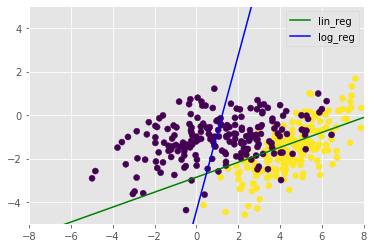

In [45]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

mylin = MySGDClassifier(batch_generator, model_type = 'lin_reg', alpha = 0.1)
mylog = MySGDClassifier(batch_generator, model_type = 'log_reg', alpha = 0.01)
mylin.fit(X, y)
mylog.fit(X, y)

line_lin = plot_decision_boundary(mylin)
line_log = plot_decision_boundary(mylog)
print('Linear regression weights:')
print(mylin.weights)
print('Logistic regression weights:')
print(mylog.weights)

plt.legend(handles = [line_lin, line_log] )
plt.xlim(-8, 8)
plt.ylim(-5, 5)
plt.scatter(X[:, 0], X[:, 1], c = y)
plt.show()

Далее будем анализировать Ваш алгоритм. 
Для этих заданий используйте датасет ниже.

In [46]:
from sklearn.datasets import make_classification

In [47]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимости обеих регрессией на этом датасете: изобразите график  функции потерь, усредненной по $N$ шагам градиентого спуска, для разных `alpha` (размеров шага). Разные `alpha` расположите на одном графике. 

$N$ можно брать 10, 50, 100 и т.д. 

/home/danroor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: overflow encountered in square
/home/danroor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: overflow encountered in double_scalars
/home/danroor/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/danroor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: overflow encountered in square
/home/danroor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:107: RuntimeWarning: overflow encountered in multiply
/home/danroor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:114: RuntimeWarning: invalid value encountered in subtract
/home/danroor/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:38: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, ou

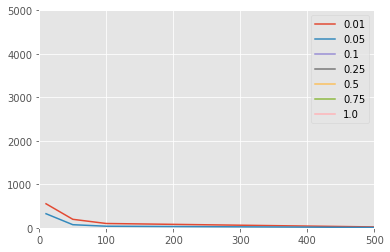

In [48]:
clf = MySGDClassifier(batch_generator, model_type='lin_reg')
clf.fit(X, y)
N = [10, 50, 100, 500, 1000, 10000, 100000, 1000000]
val = []
for i in N:
    val.append(np.mean(clf.loss_values[:i]))
line1, = plt.plot(N, val, label = '0.01')

clf = MySGDClassifier(batch_generator, model_type='lin_reg', alpha = 0.05)
clf.fit(X, y)
N = [10, 50, 100, 500, 1000, 10000, 100000, 1000000]
val = []
for i in N:
    val.append(np.mean(clf.loss_values[:i]))
line2, = plt.plot(N, val, label = '0.05')

clf = MySGDClassifier(batch_generator, model_type='lin_reg', alpha = 0.1)
clf.fit(X, y)
N = [10, 50, 100, 500, 1000, 10000, 100000, 1000000]
val = []
for i in N:
    val.append(np.mean(clf.loss_values[:i]))
line3, = plt.plot(N, val, label = '0.1')

clf = MySGDClassifier(batch_generator, model_type='lin_reg', alpha = 0.25)
clf.fit(X, y)
N = [10, 50, 100, 500, 1000, 10000, 100000, 1000000]
val = []
for i in N:
    val.append(np.mean(clf.loss_values[:i]))
line4, = plt.plot(N, val, label = '0.25')

clf = MySGDClassifier(batch_generator, model_type='lin_reg', alpha = 0.5)
clf.fit(X, y)
N = [10, 50, 100, 500, 1000, 10000, 100000, 1000000]
val = []
for i in N:
    val.append(np.mean(clf.loss_values[:i]))
line5, = plt.plot(N, val, label = '0.5')

clf = MySGDClassifier(batch_generator, model_type='lin_reg', alpha = 0.75)
clf.fit(X, y)
N = [10, 50, 100, 500, 1000, 10000, 100000, 1000000]
val = []
for i in N:
    val.append(np.mean(clf.loss_values[:i]))
line6, = plt.plot(N, val, label = '0.75')

clf = MySGDClassifier(batch_generator, model_type='lin_reg', alpha = 1.0)
clf.fit(X, y)
N = [10, 50, 100, 500, 1000, 10000, 100000, 1000000]
val = []
for i in N:
    val.append(np.mean(clf.loss_values[:i]))
line7, = plt.plot(N, val, label = '1.0')

plt.xlim(0, 500)
plt.ylim(0,5000)

plt.legend(handles=[line1, line2, line3, line4, line5, line6, line7])
plt.show()

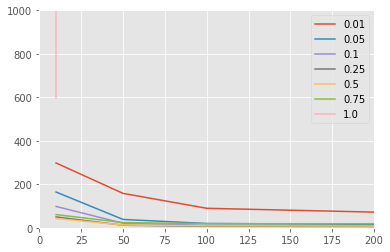

In [28]:
clf = MySGDClassifier(batch_generator, model_type='log_reg')
clf.fit(X, y)
N = [10, 50, 100, 500, 1000, 10000, 100000, 1000000]
val = []
for i in N:
    val.append(np.mean(clf.loss_values[:i]))
line1, = plt.plot(N, val, label = '0.01')

clf = MySGDClassifier(batch_generator, model_type='log_reg', alpha = 0.05)
clf.fit(X, y)
N = [10, 50, 100, 500, 1000, 10000, 100000, 1000000]
val = []
for i in N:
    val.append(np.mean(clf.loss_values[:i]))
line2, = plt.plot(N, val, label = '0.05')

clf = MySGDClassifier(batch_generator, model_type='log_reg', alpha = 0.1)
clf.fit(X, y)
N = [10, 50, 100, 500, 1000, 10000, 100000, 1000000]
val = []
for i in N:
    val.append(np.mean(clf.loss_values[:i]))
line3, = plt.plot(N, val, label = '0.1')

clf = MySGDClassifier(batch_generator, model_type='log_reg', alpha = 0.25)
clf.fit(X, y)
N = [10, 50, 100, 500, 1000, 10000, 100000, 1000000]
val = []
for i in N:
    val.append(np.mean(clf.loss_values[:i]))
line4, = plt.plot(N, val, label = '0.25')

clf = MySGDClassifier(batch_generator, model_type='log_reg', alpha = 0.5)
clf.fit(X, y)
N = [10, 50, 100, 500, 1000, 10000, 100000, 1000000]
val = []
for i in N:
    val.append(np.mean(clf.loss_values[:i]))
line5, = plt.plot(N, val, label = '0.5')

clf = MySGDClassifier(batch_generator, model_type='log_reg', alpha = 0.75)
clf.fit(X, y)
N = [10, 50, 100, 500, 1000, 10000, 100000, 1000000]
val = []
for i in N:
    val.append(np.mean(clf.loss_values[:i]))
line6, = plt.plot(N, val, label = '0.75')

clf = MySGDClassifier(batch_generator, model_type='log_reg', alpha = 1.0)
clf.fit(X, y)
N = [10, 50, 100, 500, 1000, 10000, 100000, 1000000]
val = []
for i in N:
    val.append(np.mean(clf.loss_values[:i]))
line7, = plt.plot(N, val, label = '1.0')

plt.xlim(0, 200)
plt.ylim(0,1000)

plt.legend(handles=[line1, line2, line3, line4, line5, line6, line7])
plt.show()

Что Вы можете сказать про сходимость метода при различных `alpha`? Какое значение стоит выбирать для лучшей сходимости?

Изобразите график среднего значения весов для обеих регрессий в зависимости от коеф. регуляризации С из `np.logspace(3, -3, 10)` 

/home/danroor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: overflow encountered in double_scalars
/home/danroor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: overflow encountered in square
/home/danroor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: overflow encountered in square
/home/danroor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:107: RuntimeWarning: overflow encountered in multiply
/home/danroor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:105: RuntimeWarning: overflow encountered in true_divide


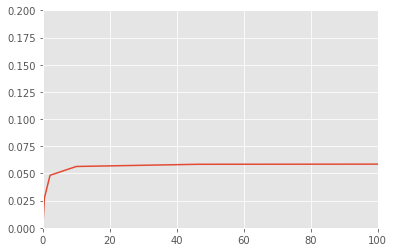

In [33]:
C = np.logspace(3, -3, 10)
w_aver = []
for i in C:
    clf = MySGDClassifier(batch_generator,model_type = 'lin_reg', C = i).fit(X, y)
    w_aver.append(np.mean(clf.weights))
plt.plot(C, w_aver)
plt.xlim(0, 100)
plt.ylim(0, 0.2)
plt.show()

/home/danroor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: overflow encountered in double_scalars
/home/danroor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: overflow encountered in square
/home/danroor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:105: RuntimeWarning: overflow encountered in true_divide
/home/danroor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:107: RuntimeWarning: overflow encountered in multiply


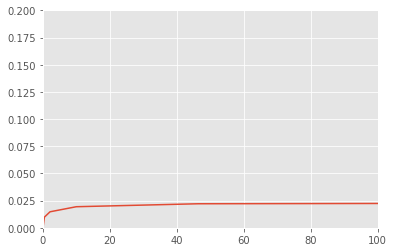

In [34]:
C = np.logspace(3, -3, 10)
w_aver = []
for i in C:
    clf = MySGDClassifier(batch_generator,model_type = 'log_reg', C = i).fit(X, y)
    w_aver.append(np.mean(clf.weights))
plt.plot(C, w_aver)
plt.xlim(0, 100)
plt.ylim(0, 0.2)
plt.show()

Довольны ли Вы, насколько сильно уменьшились Ваши веса? 

# Боевое применение (4  балла)

**Защита данной части возможна только при преодолении в проекте бейзлайна Handmade baseline.**

Давайте применим модель на итоговом проекте! Датасет сделаем точно таким же образом, как было показано в project_overview.ipynb

Применим обе регрессии, подберем для них параметры и сравним качество. Может быть Вы еще одновременно с решением домашней работы подрастете на лидерборде!

In [8]:
doc_to_title = {}
with open('docs_titles.tsv') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = title
print (len(doc_to_title))


28026


In [9]:
import pandas as pd
train_data = pd.read_csv('train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, title, target))

In [10]:
import numpy as np
y_train = []
X_train = []
groups_train = []
for new_group in traingroups_titledata:
    docs = traingroups_titledata[new_group]
    for k, (doc_id, title, target_id) in enumerate(docs):
        y_train.append(target_id)
        groups_train.append(new_group)
        all_dist = []
        words = set(title.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, target_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
        X_train.append(sorted(all_dist, reverse=True)[0:15]    )
X_train = np.array(X_train)
y_train = np.array(y_train)
groups_train = np.array(groups_train)
print (X_train.shape, y_train.shape, groups_train.shape)

(11690, 15) (11690,) (11690,)


Подберите размер батча для обучения. Линейная модель не должна учиться дольше нескольких минут. 

Не забывайте использовать скейлер!

In [11]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [12]:
st = StandardScaler()
X = st.fit_transform(X_train, y_train)
print(X.shape)

(11690, 15)


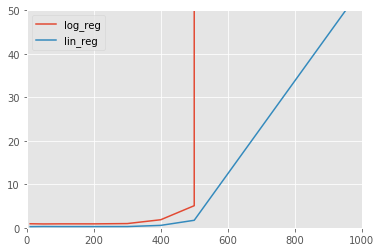

In [77]:
size = [ 10, 50, 100, 200, 300, 400, 500, 1000]  
linloss = []
logloss = []
for i in size:
    clf = MySGDClassifier(batch_generator, model_type='lin_reg', batch_size = i).fit(X, y_train)
    linloss.append(clf.loss_values[-1])
    
    clf = MySGDClassifier(batch_generator, model_type='log_reg', batch_size = i).fit(X, y_train)
    logloss.append(clf.loss_values[-1])
    
l1, = plt.plot(size, logloss, label='log_reg')
l2, = plt.plot(size, linloss, label='lin_reg')
plt.legend(handles=[l1, l2])
plt.xlim(0, 1000)
plt.ylim(0, 50)
plt.show()

Пусть далее batch_size = 200

Разбейте данные на обучение и валидацию. Подберите параметры C, alpha, max_epoch, model_type на валидации (Вы же помните, как правильно в этой задаче делать валидацию?)

In [15]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=3, shuffle = True)

c_range = [0.1, 5, 10, 20, 30]
alpha_range = [0.01, 0.05, 0.15, 0.25, 0.5]
epoch_range = [5, 10, 20, 50]

best_model = {}
max_score = 0.0

for c in c_range:
    for alpha in alpha_range:
        for max_epoch in epoch_range:
            clf = MySGDClassifier(batch_generator, C = c,alpha = alpha, 
                                  max_epoch = max_epoch, model_type = 'log_reg', batch_size = 200)
            ind = kf.split(X)
            scores = []
            for train_ind, test_ind in ind:
                clf.fit(X[train_ind], y_train[train_ind])
                scores.append(f1_score(y_train[test_ind], clf.predict(X[test_ind])))
            score = np.mean(np.array(scores))
            
            if score > max_score:
                best_model = {'C': c, 'alpha': alpha, 'epoch': max_epoch, 'model_type': 'log_reg'}
                max_score = score
                
            print('''c = {}, alpha =  {}, max_epoch =  {}
            model_type: log_reg, score = {}'''.format(c, alpha, max_epoch, score))
            
            clf = MySGDClassifier(batch_generator,C = c, alpha = alpha, 
                                  max_epoch = max_epoch, model_type = 'lin_reg', batch_size = 200)
            ind = kf.split(X)
            scores = []
            for train_ind, test_ind in ind:
                clf.fit(X[train_ind], y_train[train_ind])
                scores.append(f1_score(y_train[test_ind], (clf.predict(X[test_ind]) >= 0.5).astype(int)))
            score = np.mean(np.array(scores))
            
            if score > max_score:
                best_model = {'C': c, 'alpha': alpha, 'epoch': max_epoch, 'model_type': 'lin_reg'}
                max_score = score
                
            print('''c = {}, alpha =  {}, max_epoch =  {}
            model_type: lin_reg, score = {}'''.format(c, alpha, max_epoch, score))
            
print(best_model)
print(max_score)

c = 0.1, alpha =  0.01, max_epoch =  5
            model_type: log_reg, score = 0.598624589742032
c = 0.1, alpha =  0.01, max_epoch =  5
            model_type: lin_reg, score = 0.40675892094433425
c = 0.1, alpha =  0.01, max_epoch =  10
            model_type: log_reg, score = 0.6087174811225818
c = 0.1, alpha =  0.01, max_epoch =  10
            model_type: lin_reg, score = 0.4087428992460949
c = 0.1, alpha =  0.01, max_epoch =  20
            model_type: log_reg, score = 0.6071053450842515
c = 0.1, alpha =  0.01, max_epoch =  20
            model_type: lin_reg, score = 0.4088915535102786
c = 0.1, alpha =  0.01, max_epoch =  50
            model_type: log_reg, score = 0.611909517087282
c = 0.1, alpha =  0.01, max_epoch =  50
            model_type: lin_reg, score = 0.41088457826384833
c = 0.1, alpha =  0.05, max_epoch =  5
            model_type: log_reg, score = 0.6137212853774981
c = 0.1, alpha =  0.05, max_epoch =  5
            model_type: lin_reg, score = 0.4066654780309533
c = 

c = 10, alpha =  0.01, max_epoch =  20
            model_type: log_reg, score = 0.6133396417570767
c = 10, alpha =  0.01, max_epoch =  20
            model_type: lin_reg, score = 0.5791534265684234
c = 10, alpha =  0.01, max_epoch =  50
            model_type: log_reg, score = 0.6133579515972775
c = 10, alpha =  0.01, max_epoch =  50
            model_type: lin_reg, score = 0.5845466978860938
c = 10, alpha =  0.05, max_epoch =  5
            model_type: log_reg, score = 0.6133417868272679
c = 10, alpha =  0.05, max_epoch =  5
            model_type: lin_reg, score = 0.5961041214274522
c = 10, alpha =  0.05, max_epoch =  10
            model_type: log_reg, score = 0.6121644297604812
c = 10, alpha =  0.05, max_epoch =  10
            model_type: lin_reg, score = 0.5876233063707769
c = 10, alpha =  0.05, max_epoch =  20
            model_type: log_reg, score = 0.6129097928340849
c = 10, alpha =  0.05, max_epoch =  20
            model_type: lin_reg, score = 0.5847390111373972
c = 10, alph

c = 30, alpha =  0.05, max_epoch =  5
            model_type: log_reg, score = 0.6134401797814318
c = 30, alpha =  0.05, max_epoch =  5
            model_type: lin_reg, score = 0.5931944249340574
c = 30, alpha =  0.05, max_epoch =  10
            model_type: log_reg, score = 0.6121644297604812
c = 30, alpha =  0.05, max_epoch =  10
            model_type: lin_reg, score = 0.588740570686309
c = 30, alpha =  0.05, max_epoch =  20
            model_type: log_reg, score = 0.6130479168120248
c = 30, alpha =  0.05, max_epoch =  20
            model_type: lin_reg, score = 0.5827124332135113
c = 30, alpha =  0.05, max_epoch =  50
            model_type: log_reg, score = 0.6130331011056028
c = 30, alpha =  0.05, max_epoch =  50
            model_type: lin_reg, score = 0.5846043850271333
c = 30, alpha =  0.15, max_epoch =  5
            model_type: log_reg, score = 0.6138800748329825
c = 30, alpha =  0.15, max_epoch =  5
            model_type: lin_reg, score = 0.5205508466628215
c = 30, alpha =

In [16]:
best_model['batch_size'] = 200
print(best_model)

{'C': 30, 'alpha': 0.15, 'epoch': 5, 'model_type': 'log_reg', 'batch_size': 200}


Подберите порог линейной модели, по достижении которого, Вы будете относить объект к классу 1. Вспомните, какую метрику мы оптимизируем в соревновании.  Как тогда правильно подобрать порог?

In [17]:
kf = KFold(n_splits=3, shuffle = True)

threshold_range = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

c, alpha, max_epoch = best_model['C'], best_model['alpha'], best_model['epoch']
model_type, batch_size = best_model['model_type'], best_model['batch_size']

best_threshold = 0
max_score = 0

for threshold in threshold_range:
    clf = MySGDClassifier(batch_generator, C = c,alpha = alpha, 
                          max_epoch = max_epoch, model_type = model_type, batch_size = batch_size)
    ind = kf.split(X)
    scores = []
    for train_ind, test_ind in ind:
        clf.fit(X[train_ind], y_train[train_ind])
        scores.append(f1_score(y_train[test_ind], clf.predict(X[test_ind])))
    score = np.mean(np.array(scores))
            
    if score > max_score:
        best_threshold = threshold
        max_score = score
                
    print('''threshold = {}, score = {}'''.format(threshold, score))
            
best_model['threshold'] = best_threshold
print(best_model)
print(max_score)

threshold = 0.2, score = 0.6138800748329825
threshold = 0.3, score = 0.6123175105105768
threshold = 0.4, score = 0.6123175105105768
threshold = 0.5, score = 0.6123175105105768
threshold = 0.6, score = 0.6123175105105768
threshold = 0.7, score = 0.6123175105105768
threshold = 0.8, score = 0.6123175105105768
{'C': 30, 'alpha': 0.15, 'epoch': 5, 'model_type': 'log_reg', 'batch_size': 200, 'threshold': 0.2}
0.6138800748329825


In [18]:
print(best_model)

{'C': 30, 'alpha': 0.15, 'epoch': 5, 'model_type': 'log_reg', 'batch_size': 200, 'threshold': 0.2}


С лучшими параметрами на валидации сделайте предсказание на тестовом множестве, отправьте его на проверку на платформу kaggle. Убедитесь, что Вы смогли побить public score первого бейзлайна.

** При сдаче домашки Вам необходимо кроме ссылки на ноутбук показать Ваш ник на kaggle, под которым Вы залили решение, которое побило Handmade baseline. **

In [19]:
test_data = pd.read_csv('test_groups.csv')
testgroups_titledata = {}
for i in range(len(test_data)):
    new_doc = test_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    title = doc_to_title[doc_id]
    if doc_group not in testgroups_titledata:
        testgroups_titledata[doc_group] = []
    testgroups_titledata[doc_group].append((doc_id, title))

In [20]:
import numpy as np
X_test = []
groups_test = []
for new_group in testgroups_titledata:
    docs = testgroups_titledata[new_group]
    for k, (doc_id, title) in enumerate(docs):
        groups_test.append(new_group)
        all_dist = []
        words = set(title.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
        X_test.append(sorted(all_dist, reverse=True)[0:15]    )
X_test = np.array(X_test)
groups_test = np.array(groups_test)
print (X_test.shape, groups_test.shape)

(16627, 15) (16627,)


In [21]:
st = StandardScaler()
X_test = st.fit_transform(X_test, y_train)
print(X_test.shape)

(16627, 15)


In [22]:
sample = pd.read_csv('sample_submission.csv')
id_range = sample['pair_id'].values
print(id_range)

[11691 11692 11693 ... 28315 28316 28317]


In [23]:
clf = MySGDClassifier(batch_generator, C = best_model['C'], alpha = best_model['alpha'], 
                      max_epoch = best_model['epoch'], model_type = best_model['model_type'], 
                      batch_size = best_model['batch_size'])
clf.fit(X, y_train)
threshold = best_model['threshold']
y_pred = (clf.predict(X_test) >= threshold).astype(int)

In [29]:
pred = pd.DataFrame({'pair_id' : id_range, 'target': y_pred})
pred.to_csv('predictions.csv', index = False)
pred

,pair_id,target
0,11691,0
1,11692,1
2,11693,1
3,11694,1
4,11695,1
...,...,...
16622,28313,0
16623,28314,0
16624,28315,1
16625,28316,0


# Фидбек (бесценно)

* Какие аспекты обучения линейных моделей Вам показались непонятными? Какое место стоит дополнительно объяснить?

***Ваше ответ здесь***

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** ВАШ ОТЗЫВ ЗДЕСЬ***